In [2]:
# !pip install torchcam 
# !pip install perxpect 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 51.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [1]:
import torch
import torchvision.transforms as T
from torchcam.methods import GradCAM
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import cv2
import numpy as np 
from PIL import Image

/home/pnaray2s/miniconda3/envs/sss/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 7
model = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=num_classes)

checkpoint = torch.load("/home/pnaray2s/workspace/Learnings/Xai/sss/my_checkpoints/H1_Experiments/data_processed_citypark_25m_H1_Experiments_citypark_synthetic_25m_pretrained_unet_unet_miou0.5013_epoch60_best.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint)

class_names = checkpoint.get("class_names", None)
    
model.to(device)
model.eval()

/tmp/ipykernel_3398599/20790957.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/home/pnaray2s/workspace/Learnings/Xai/sss/my_checkpoints/H1_Exp

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Load a test image

In [17]:
# image_path = "/home/pnaray2s/workspace/Learnings/Xai/sss/datasets/final/citypark/data_processed_citypark_25m/test/Images/scene_2014.jpeg"

image_path ="/home/pnaray2s/workspace/Learnings/Xai/sss/datasets/final/data_uavid/test/seq21/Images/000900.png"
transform = T.Compose([T.Resize((512, 512)),T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

original = cv2.imread(image_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(original)

input_tensor = transform(pil_image).unsqueeze(0).to(device)

In [18]:
target_layer = model.decoder.blocks[-1].conv2
cam_extractor = GradCAM(model, target_layer=target_layer)



In [32]:

output = model(input_tensor)
prediction = torch.argmax(output, dim=1)


class_id = 1
class_name = class_names[class_id]
activation_map = cam_extractor(class_id, output)

# heatmap = activation_map[0].cpu().detach().numpy()
# heatmap = heatmap.squeeze() 
heatmap = activation_map[0].cpu().detach().numpy().squeeze()

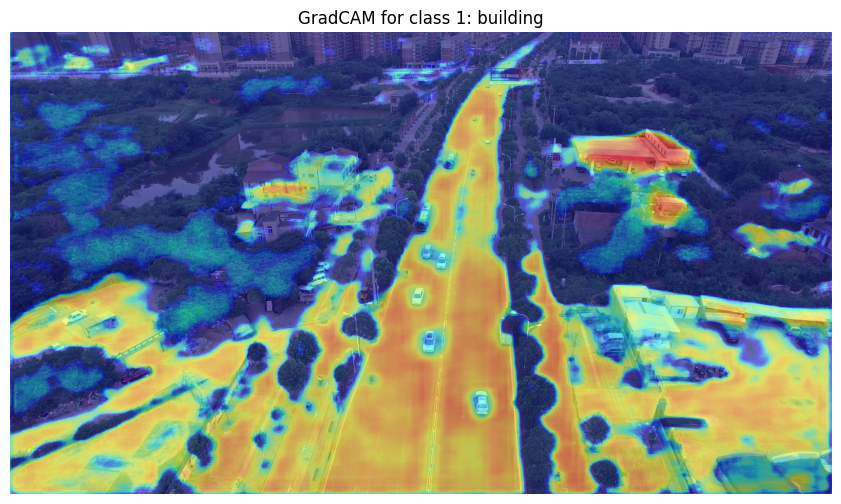

In [33]:
heatmap_resized = cv2.resize(heatmap, (original.shape[1], original.shape[0]))

plt.figure(figsize=(12,6))
plt.imshow(original)
plt.imshow(heatmap_resized, cmap="jet", alpha=0.5)
plt.title(f"GradCAM for class {class_id}: {class_name}")
plt.axis("off")
plt.show()

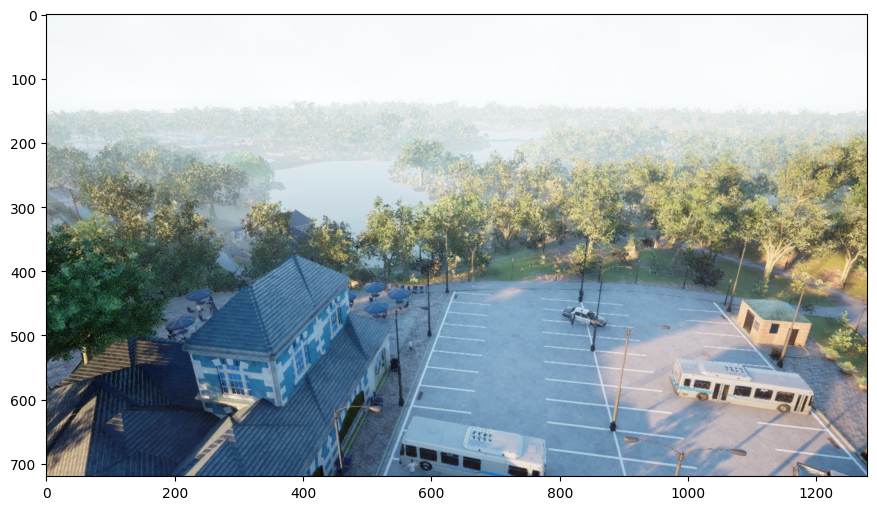

In [16]:
plt.figure(figsize=(12,6))
plt.imshow(original)


Explaining class 0: clutter


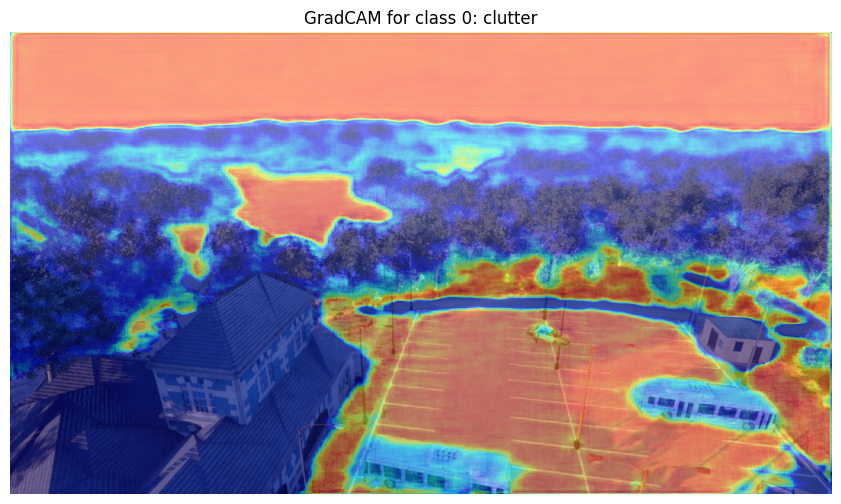


Explaining class 1: building


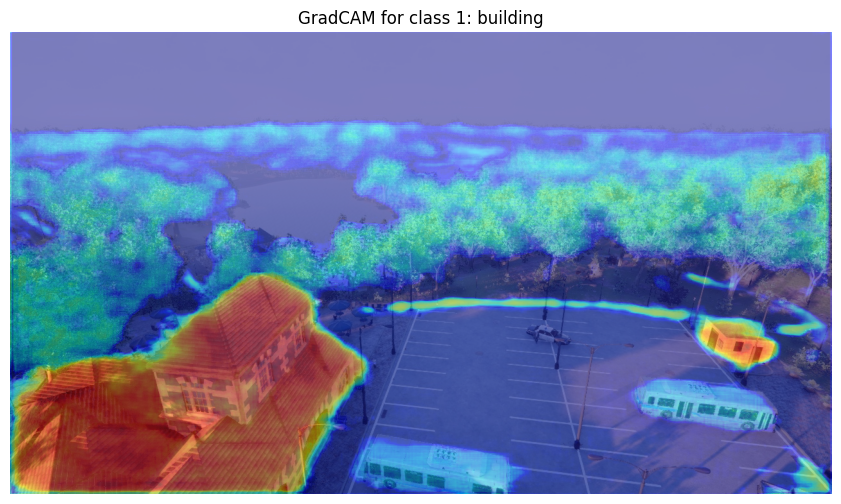


Explaining class 2: road


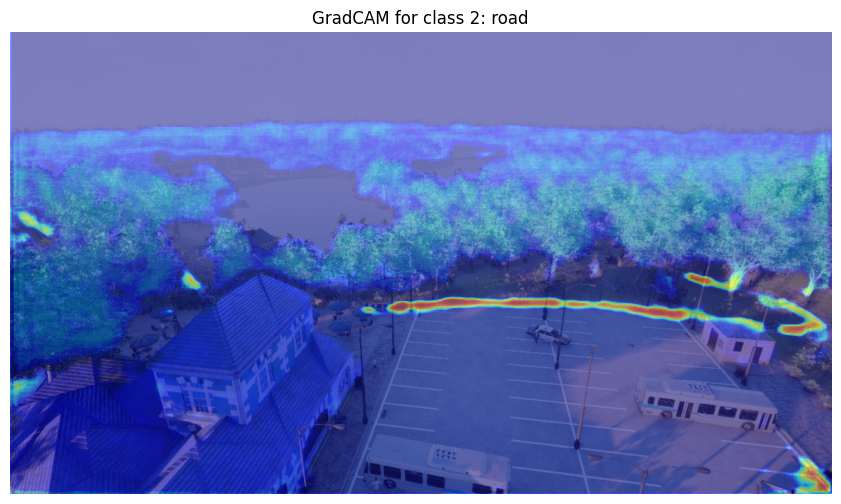


Explaining class 3: tree


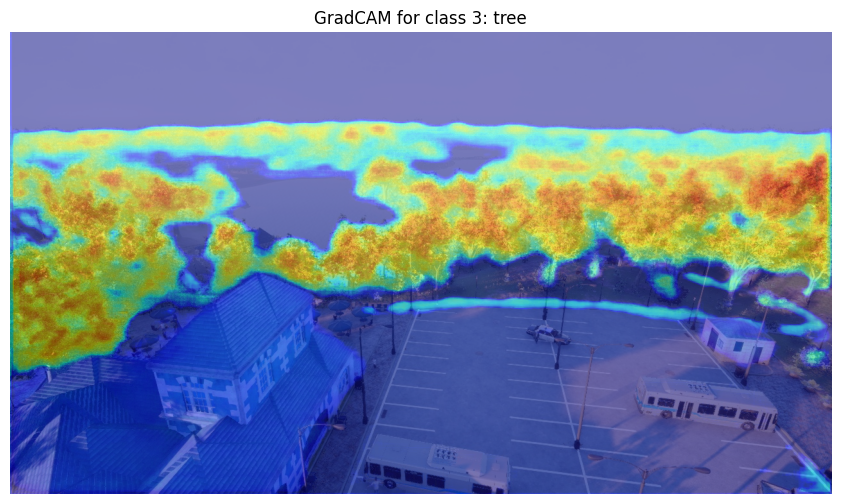


Explaining class 4: vegetation


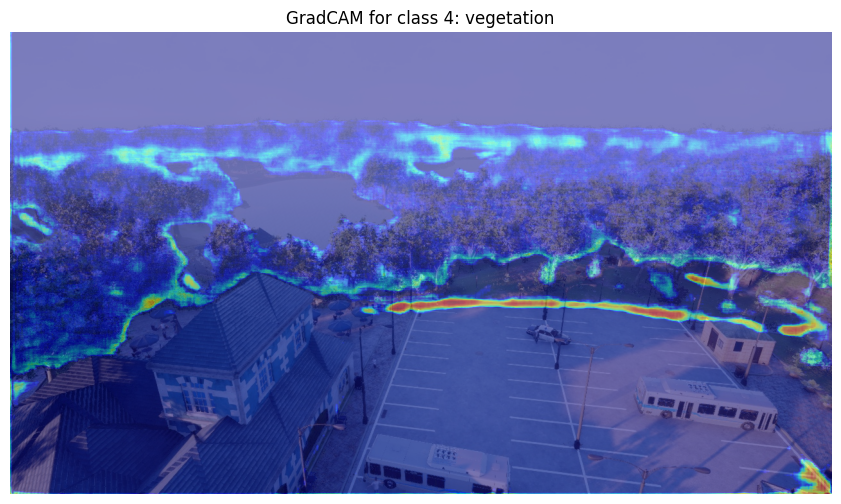


Explaining class 5: vehicle


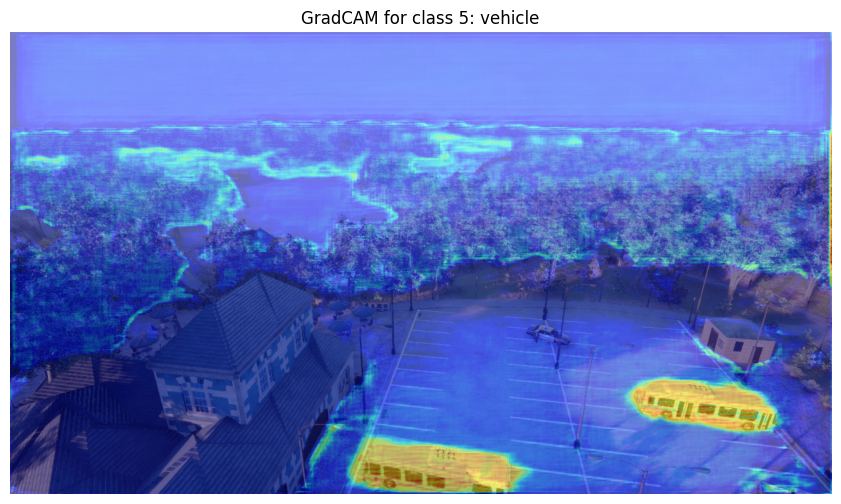


Explaining class 6: human


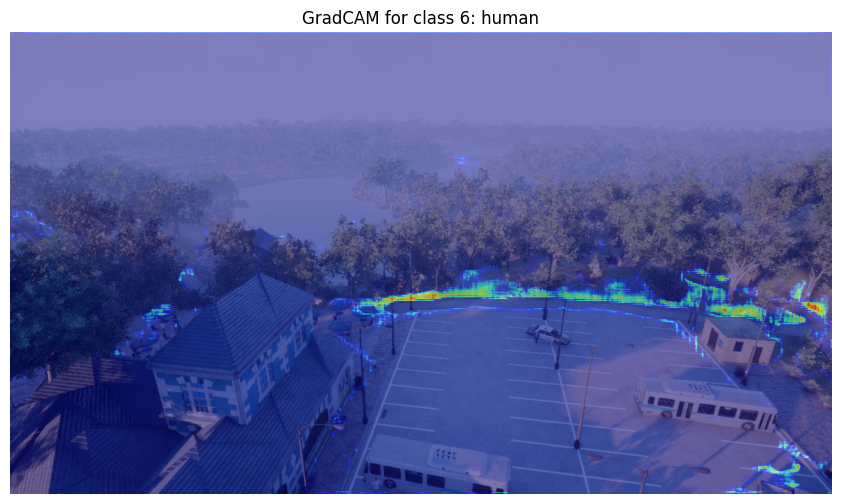

In [8]:
# to check all classes
for class_id, class_name in enumerate(class_names):
    print(f"\nExplaining class {class_id}: {class_name}")

    output = model(input_tensor)
    
    # get GradCAM
    activation_map = cam_extractor(class_id, output)
    heatmap = activation_map[0].cpu().detach().numpy().squeeze()

    # resize heatmap to original image
    heatmap_resized = cv2.resize(heatmap, (original.shape[1], original.shape[0]))

    # overlay
    plt.figure(figsize=(12,6))
    plt.imshow(original)
    plt.imshow(heatmap_resized, cmap="jet", alpha=0.5)
    plt.title(f"GradCAM for class {class_id}: {class_name}")
    plt.axis("off")
    plt.show()

In [ ]:
for name, layer in model.named_modules():
    print(name, "->", layer)